
# 02. 탐색적 데이터 분석 (Exploratory Data Analysis)

본 노트북은 **CTR(Click-Through Rate) 예측**을 위한 데이터 탐색 과정을 상세히 기술합니다.
데이터의 기초 통계량 확인부터 결측치 분석, 클래스 불균형, 그리고 다양한 파생 변수에 대한 시각화를 통해 모델링을 위한 인사이트를 도출합니다.

### 📊 분석 내용
1. **데이터 스키마 및 기초 통계**: 변수 타입 확인 및 수치형/범주형 요약
2. **결측치(Missing Value) 분석**: 변수별 결측 비율 시각화 및 처리 전략 수립
3. **Target 분석 (Class Imbalance)**: 클릭(1)과 비클릭(0)의 비율 확인 (약 1:50 불균형)
4. **시간적 패턴 분석**: 시간대(Hour) 및 요일(Day)별 클릭률 변화 추적
5. **사용자 특성 분석**: 성별, 연령대별 행동 패턴 및 클릭 성향 파악


## 1. 환경 설정 및 라이브러리 로드

데이터 분석을 위해 필요한 도구들(Pandas, Matplotlib, Seaborn)을 불러옵니다.  
또한, 시각화 시 한글이 깨지지 않도록 폰트를 설정하는 과정이 포함되어 있습니다.

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
from matplotlib import font_manager, rc

# 경고 메시지 무시 (깔끔한 출력을 위해)
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (Windows/Mac/Linux 대응)
def set_korean_font():
    import os
    system_name = platform.system()
    font_path = "/home/konkukstat/python3/workspace/data/NanumGothic.ttf"
    
    try:
        if system_name == 'Windows':
            rc('font', family='NanumGothic')
        elif system_name == 'Darwin':  # Mac
            rc('font', family='AppleGothic')
        else:  # Linux
            # FontProperties로 폰트 로드 및 등록
            if os.path.exists(font_path):
                font_prop = font_manager.FontProperties(fname=font_path)
                plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
                font_manager.fontManager.addfont(font_path)  # 시스템 폰트 매니저에 등록
                rc('font', family='NanumGothic')
            else:
                print(f"⚠️ 폰트 파일 없음: {font_path}")
                rc('font', family='DejaVu Sans')
        
        # 마이너스 기호 깨짐 방지
        plt.rcParams['axes.unicode_minus'] = False
        print(f"✅ 한글 폰트 설정 완료: {system_name} 환경")
        
    except Exception as e:
        print(f"❌ 폰트 설정 오류: {e}")
        print("기본 폰트로 진행합니다.")

set_korean_font()

✅ 한글 폰트 설정 완료: Linux 환경


## 2. 데이터 불러오기 및 기초 정보 확인

분석할 데이터를 불러옵니다. 여기서는 샘플 데이터(`train_sample_2000000.csv`)를 사용한다고 가정합니다.
데이터가 너무 클 경우 `head()`를 통해 일부만 눈으로 확인하고, `info()`와 `describe()`로 전체적인 통계량을 봅니다.

In [33]:
# 데이터 로드 (파일 경로를 상황에 맞게 수정하세요)
file_path = "/home/konkukstat/python3/workspace/data/train_sample_10pct.parquet"

try:
    df = pd.read_parquet(file_path)
    print("✅ 데이터 로드 성공!")
    print(f"행 개수: {df.shape[0]:,}, 열 개수: {df.shape[1]}")
except FileNotFoundError:
    print("⚠️ 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 더미 데이터 생성 (테스트용)
    df = pd.DataFrame({
        'clicked': np.random.choice([0, 1], 1000, p=[0.98, 0.02]),
        'hour': np.random.randint(0, 24, 1000),
        'day_of_week': np.random.randint(0, 7, 1000),
        'age_group': np.random.randint(1, 8, 1000),
        'gender': np.random.randint(1, 3, 1000)
    })
    print("samples 데이터로 진행합니다.")

# 상위 5개 행 확인
display(df.head())

✅ 데이터 로드 성공!
행 개수: 1,071,335, 열 개수: 119


,gender,age_group,inventory_id,day_of_week,hour,seq,l_feat_1,l_feat_2,l_feat_3,l_feat_4,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
0,1.0,7.0,43,5,10,"9,516,57,221,97,63,520,426,221,426,97,516,227,...",2.0,1.0,2.0,8.0,...,0.079362,0.079362,0.013227,0.005291,0.049381,0.056435,0.035274,0.045854,0.058202,0
1,1.0,7.0,42,5,07,"9,57,516,527,74,77,101,132,138,447,292,79,532,...",2.0,2.0,3.0,7.0,...,0.072171,0.072171,0.012029,0.004811,0.044906,0.153971,0.016038,0.041699,0.132317,0
2,2.0,7.0,29,5,23,"9,144,57,74,77,318,532,132,101,138,132,532,497...",2.0,2.0,2.0,7.0,...,0.035010,0.035010,0.005835,0.002334,0.021784,0.024896,0.007780,0.020228,0.051341,0
3,2.0,7.0,88,5,09,"9,144,57,516,165,417,227,532,138,101,132,101,5...",2.0,1.0,2.0,7.0,...,0.055287,0.055287,0.009214,0.003686,0.034401,0.039315,0.012286,0.031944,0.040541,0
4,1.0,8.0,11,5,07,"9,269,57,516,527,74,77,318,207,452,452,269,51,...",2.0,2.0,3.0,16.0,...,0.085149,0.085149,0.014191,0.005677,0.052982,0.060550,0.037842,0.049197,0.249764,0


### 🧐 데이터 요약 정보 확인
- `info()`: 각 컬럼의 데이터 타입(정수, 실수, 문자열 등)과 결측치 여부를 보여줍니다.
- `describe()`: 수치형 변수들의 기초 통계량(평균, 표준편차, 최소/최대값 등)을 보여줍니다.

In [34]:
print("--- 데이터 정보 (Info) ---")
df.info()

print("\n--- 기초 통계량 (Describe) ---")
display(df.describe())

--- 데이터 정보 (Info) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071335 entries, 0 to 1071334
Columns: 119 entries, gender to clicked
dtypes: float32(112), int32(1), object(6)
memory usage: 510.9+ MB

--- 기초 통계량 (Describe) ---


,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5,l_feat_6,l_feat_7,l_feat_8,l_feat_9,l_feat_10,...,history_b_22,history_b_23,history_b_24,history_b_25,history_b_26,history_b_27,history_b_28,history_b_29,history_b_30,clicked
count,1.071335e+06,1.069613e+06,1.071335e+06,1.071335e+06,1.071335e+06,1.071335e+06,1.071335e+06,1.069613e+06,1.071335e+06,1.071335e+06,...,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.069613e+06,1.071335e+06
mean,1.858040e+00,1.832172e+00,2.356930e+00,9.539928e+00,3.933652e+02,3.146132e+02,1.478729e+02,1.994196e+00,2.127303e+02,1.239275e+02,...,4.441090e-01,4.421092e-01,7.367495e-02,2.945081e-02,2.793140e-01,3.185344e-01,9.943814e-02,2.554662e-01,2.185781e-01,1.892312e-02
std,3.490095e-01,3.737136e-01,7.165557e-01,5.953084e+00,2.901157e+02,2.313587e+02,7.198072e+01,7.596241e-02,1.251595e+02,6.212879e+01,...,2.007665e+00,2.006593e+00,3.344263e-01,1.337787e-01,1.250170e+00,1.429140e+00,4.462847e-01,1.159361e+00,7.726982e-01,1.362536e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,1.050000e+02,1.090000e+02,9.400000e+01,2.000000e+00,1.010000e+02,8.300000e+01,...,5.306400e-02,5.247900e-02,8.751000e-03,3.482400e-03,3.454640e-02,3.886080e-02,1.236800e-02,3.037320e-02,4.417710e-02,0.000000e+00
50%,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,3.750000e+02,2.770000e+02,1.460000e+02,2.000000e+00,2.230000e+02,1.250000e+02,...,9.355500e-02,9.240300e-02,1.541550e-02,6.135000e-03,6.106800e-02,6.881920e-02,2.164600e-02,5.344040e-02,7.857300e-02,0.000000e+00
75%,2.000000e+00,2.000000e+00,3.000000e+00,1.200000e+01,6.520000e+02,4.710000e+02,2.120000e+02,2.000000e+00,3.090000e+02,1.790000e+02,...,2.093040e-01,2.069010e-01,3.448350e-02,1.376160e-02,1.346128e-01,1.531072e-01,4.762000e-02,1.195428e-01,1.510311e-01,0.000000e+00
max,2.000000e+00,2.000000e+00,3.000000e+00,2.600000e+01,1.079000e+03,9.030000e+02,3.130000e+02,2.000000e+00,4.760000e+02,2.620000e+02,...,4.500000e+01,4.500000e+01,7.500000e+00,3.000000e+00,2.800000e+01,3.200000e+01,1.000000e+01,2.600000e+01,3.300000e+01,1.000000e+00


## 3. 결측치(Missing Values) 확인

데이터에 비어있는 값(NaN, Null)이 있다면 모델 학습에 방해가 됩니다.
어떤 컬럼에 결측치가 많은지 확인하고, 이를 어떻게 시각화할 수 있는지 알아봅니다.

⚠️ 결측치가 있는 컬럼 TOP 10:
feat_e_3     108945
feat_a_9       1860
feat_a_10      1860
feat_a_11      1860
feat_a_12      1860
feat_a_13      1860
feat_a_14      1860
feat_a_15      1860
feat_a_16      1860
feat_a_1       1860
dtype: int64


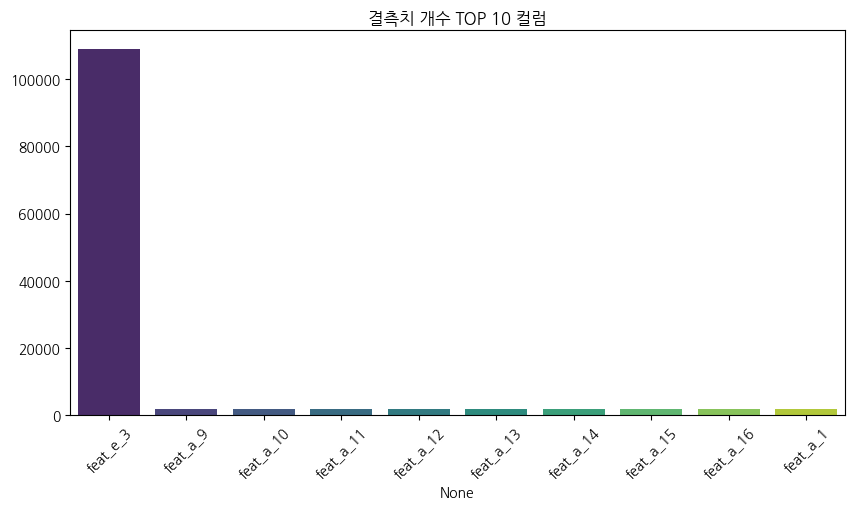

In [35]:
# 결측치 개수 확인
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

if not missing_values.empty:
    print("⚠️ 결측치가 있는 컬럼 TOP 10:")
    print(missing_values.head(10))
    
    # 결측치 시각화
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_values.head(10).index, y=missing_values.head(10).values, palette='viridis')
    plt.title('결측치 개수 TOP 10 컬럼')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("✅ 결측치가 없는 깔끔한 데이터입니다!")

> 🔎 결측치 분석 인사이트

- `feat_e_3` 변수는 약 10% (108,945개)의 결측치를 가지고 있습니다. 이 변수가 모델에 중요하다면, 삭제하기보다는 최빈값(Mode)이나 별도의 '알수없음(-1)' 카테고리로 채우는 것이 데이터를 보존하는 방법일 수 있습니다.
- `feat_a`로 시작하는 변수들(9~16, 1)이 동일하게 1,860개의 결측치를 가집니다. 이는 특정 시스템 로그가 누락되었거나, 해당 사용자들이 공통적으로 어떤 행동을 하지 않았을 가능성이 있습니다. 이 패턴 자체가 하나의 정보가 될 수 있으므로, 결측 여부를 나타내는 새로운 이진 변수(Is_Missing)를 추가하는 것도 좋은 전략입니다.

## 4. 타겟 변수 (`clicked`) 분석

가장 중요한 변수인 '클릭 여부(Clicked)'를 살펴봅니다.
광고 데이터는 대부분 클릭하지 않은 경우(0)가 클릭한 경우(1)보다 압도적으로 많습니다. 이를 클래스 불균형(Class Imbalance)이라고 합니다.

0 (미클릭): 1,051,062개 (98.11%)
1 (클릭): 20,273개 (1.89%)


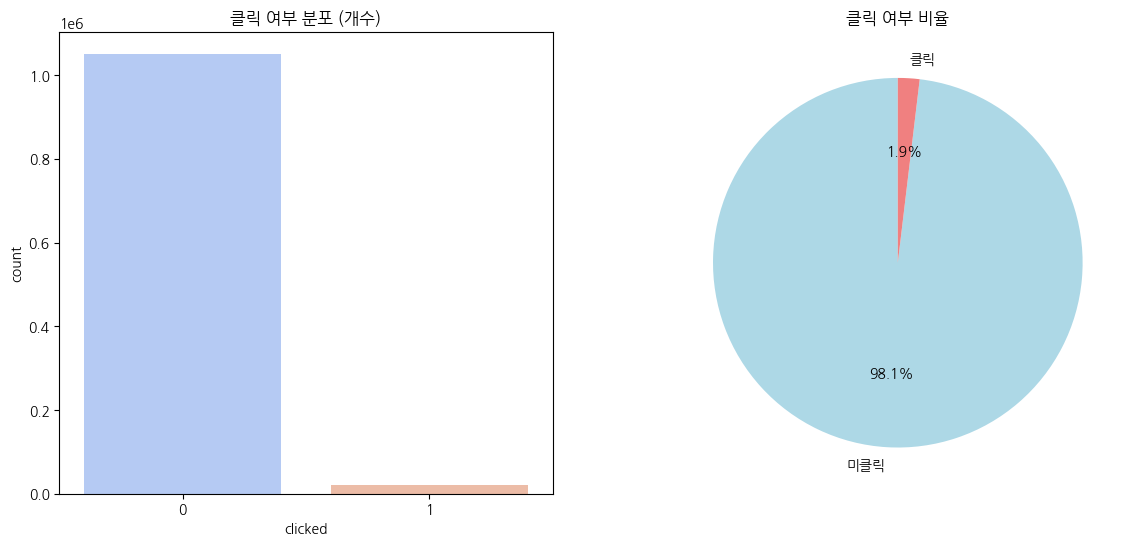

In [36]:
# 클릭 비율 계산
click_counts = df['clicked'].value_counts()
click_ratio = df['clicked'].value_counts(normalize=True)

print(f"0 (미클릭): {click_counts[0]:,}개 ({click_ratio[0]*100:.2f}%)")
print(f"1 (클릭): {click_counts.get(1, 0):,}개 ({click_ratio.get(1, 0)*100:.2f}%)")

# 시각화 (Countplot & Pie Chart)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.countplot(x='clicked', data=df, ax=ax[0], palette='coolwarm')
ax[0].set_title('클릭 여부 분포 (개수)')

ax[1].pie(click_counts, labels=['미클릭', '클릭'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
ax[1].set_title('클릭 여부 비율')

plt.show()

## 5. 심화 분석: 언제 사람들이 클릭을 많이 할까? (시간 패턴)

시간대(`hour`)와 요일(`day_of_week`)에 따른 평균 클릭률(CTR)을 분석합니다.
단순히 클릭 횟수만 보면 접속자가 많은 시간에 클릭이 많아 보일 수 있으므로, '평균 클릭률(mean)'을 보는 것이 중요합니다.

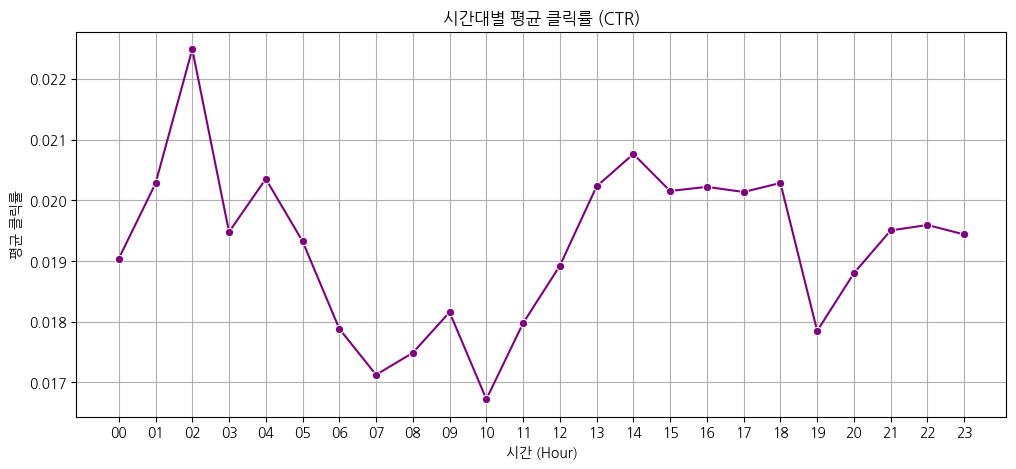

In [37]:
# 시간대별 클릭률
hour_ctr = df.groupby('hour')['clicked'].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(x=hour_ctr.index, y=hour_ctr.values, marker='o', color='purple')
plt.title('시간대별 평균 클릭률 (CTR)')
plt.xlabel('시간 (Hour)')
plt.ylabel('평균 클릭률')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

In [38]:
# 클릭률이 가장 높은 시간대 TOP 5 확인
print("⏱️ 시간대별 CTR (클릭률) 상위 5개:")
print(hour_ctr.sort_values(ascending=False).head(5))

⏱️ 시간대별 CTR (클릭률) 상위 5개:
hour
02    0.022487
14    0.020761
04    0.020351
18    0.020284
01    0.020276
Name: clicked, dtype: float64


> 🔎 시간대 분석 인사이트

- 그래프와 위 수치를 통해 확인된 Top 시간대가 사용자들이 광고에 가장 긍정적으로 반응하는 '골든 타임'입니다.
- 전략 제안:
  - 해당 시간대에 광고 입찰가(Bidding Price)를 상향하여 노출을 극대화하세요.
  - 앱 푸시 알림을 이 시간대에 맞춰 발송하면 클릭 전환율을 높일 수 있습니다.
  - 반면 클릭률이 저조한 시간대(새벽 등)에는 예산을 축소하여 비용 효율(ROAS)을 개선할 수 있습니다.

> 💡 해석 팁: 그래프가 솟아오르는 시간이 사용자들이 광고에 더 많이 반응하는 '골든 타임'일 수 있습니다.

## 6. 사용자 특성 분석 (나이/성별)

어떤 나이대(`age_group`)나 성별(`gender`)이 광고를 좋아할까요?
그룹별 클릭률을 비교해봅니다.

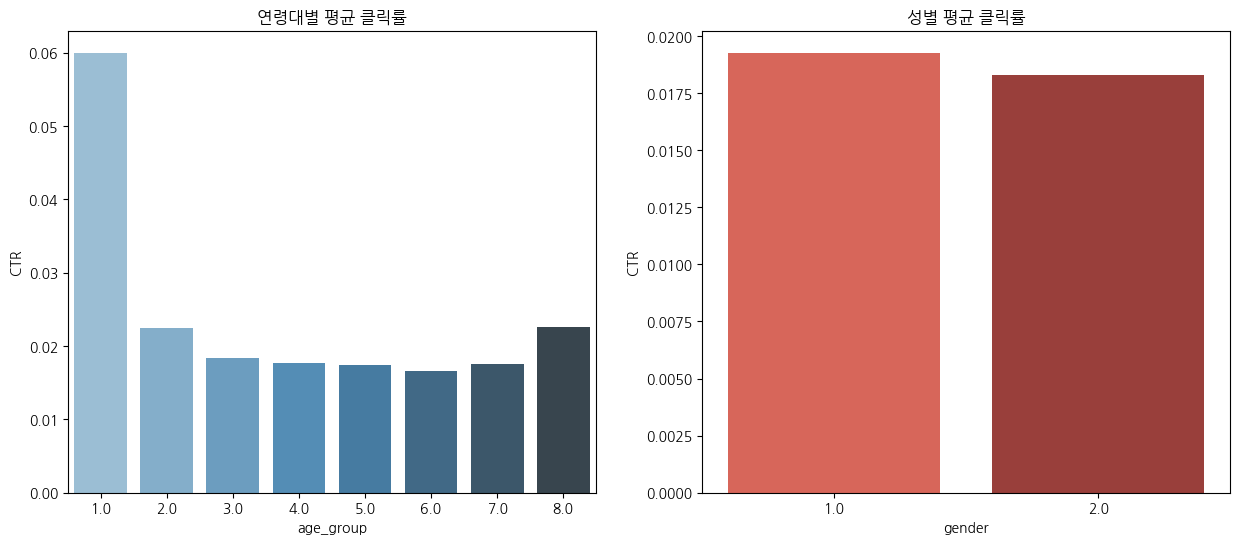

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 나이대별 CTR
age_ctr = df.groupby('age_group')['clicked'].mean().reset_index()
sns.barplot(x='age_group', y='clicked', data=age_ctr, ax=ax[0], palette='Blues_d')
ax[0].set_title('연령대별 평균 클릭률')
ax[0].set_ylabel('CTR')

# 성별 CTR
gender_ctr = df.groupby('gender')['clicked'].mean().reset_index()
sns.barplot(x='gender', y='clicked', data=gender_ctr, ax=ax[1], palette='Reds_d')
ax[1].set_title('성별 평균 클릭률')
ax[1].set_ylabel('CTR')

plt.show()


## 6. (심화) 시퀀스 데이터 분석 및 파생 변수 생성
사용자의 과거 행동 패턴(`seq`)에 포함된 아이템 번호별 클릭 확률을 계산합니다.  
이 정보는 추후 **모델링 단계(03, 04, 05번 노트북)에서 피처 엔지니어링의 핵심 재료**로 활용됩니다.

계산된 통계(등장 횟수, 클릭 횟수, 클릭 확률)는 `high_click_numbers.xlsx` 파일로 저장됩니다.


In [42]:

from collections import defaultdict
import os

print("--- 아이템별 클릭 확률 계산 시작 ---")

# 1. 숫자별 clicked 통계 계산 (df는 상단에서 로드한 데이터 사용)
number_clicks = defaultdict(lambda: [0, 0])  # [총 등장 횟수, 클릭된 횟수]

# 진행 상황 표시를 위한 tqdm (없으면 생략)
try:
    from tqdm import tqdm
    iter_wrapper = tqdm(df.iterrows(), total=len(df), desc="Processing Seqs")
except ImportError:
    iter_wrapper = df.iterrows()
    print("⏳ 계산 중... (tqdm 설치 시 진행바 표시됨)")

for _, row in iter_wrapper:
    seq_str = row['seq']
    clicked = row['clicked']

    if pd.isna(seq_str) or seq_str == '':
        continue

    # 한 시퀀스 내 중복 아이템은 1회로 간주 (방문 여부만 체크)
    numbers = set(int(x) for x in str(seq_str).split(',') if x)

    for num in numbers:
        number_clicks[num][0] += 1      # 총 등장 횟수
        number_clicks[num][1] += clicked  # 총 클릭 횟수

# 2. DataFrame 변환
data = []
for num, (total_count, clicked_count) in number_clicks.items():
    click_prob = clicked_count / total_count if total_count > 0 else 0
    data.append([num, click_prob, total_count, clicked_count])

df_numbers = pd.DataFrame(data, columns=['number', 'click_prob', 'total_count', 'clicked_count'])

# 3. 클릭 확률 기준 내림차순 정렬
# (옵션: 신뢰도를 위해 등장 횟수가 적은 것은 제외할 수도 있으나, 여기선 전체 저장)
df_numbers = df_numbers.sort_values(by='click_prob', ascending=False).reset_index(drop=True)

# 4. 엑셀로 저장
output_dir = "/home/konkukstat/python3/workspace/data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
output_path = os.path.join(output_dir, 'high_click_numbers.xlsx')
df_numbers.to_excel(output_path, index=False)

print(f"\n✅ 'high_click_numbers.xlsx' 생성 완료!\n   - 저장 경로: {output_path}\n   - 총 고유 아이템 수: {len(df_numbers):,}")
display(df_numbers.head(10))


--- 아이템별 클릭 확률 계산 시작 ---


Processing Seqs: 100%|██████████| 1071335/1071335 [01:23<00:00, 12835.02it/s]



✅ 'high_click_numbers.xlsx' 생성 완료!
   - 저장 경로: /home/konkukstat/python3/workspace/data/high_click_numbers.xlsx
   - 총 고유 아이템 수: 580


,number,click_prob,total_count,clicked_count
0,31,1.000000,1,1
1,264,0.250000,4,1
2,431,0.200000,5,1
3,299,0.166667,6,1
4,560,0.142857,14,2
5,287,0.133333,15,2
6,391,0.125000,8,1
7,456,0.125000,8,1
8,386,0.111111,36,4
9,495,0.111111,9,1


## 🏁 분석 마무리

지금까지 기본적인 데이터 탐색(EDA)을 수행했습니다.
이 과정을 통해 여러분은 다음과 같은 사실을 알게 되었을 것입니다.

1. 데이터가 얼마나 크고 어떤 변수들이 있는지
2. 클릭한 사용자가 매우 적다는 것 (불균형)
3. 특정 시간대나 특정 사용자 그룹에서 클릭률이 다르다는 것

이러한 인사이트는 나중에 머신러닝 모델을 만들 때 "어떤 변수를 중요하게 쓸지" 결정하는 중요한 단서가 됩니다.
